In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [0]:
training_set_df = pd.read_excel('Datos históricos USD_COP  BDordv2.xlsx')


training_set_df.describe()

,Index,TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_EfcRate,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20
count,1835.00000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1835.000000,1834.000000,1834.000000,1831.000000,1816.000000
mean,918.00000,2997.985030,8.002286,0.052952,0.053668,0.063617,0.072181,0.015840,0.027382,0.034068,1.077646,1.214305,53.043392,1271.414063,0.469989,0.000168,2998.363595,2999.654649
std,529.86319,243.376642,0.083400,0.012513,0.009432,0.007573,0.007521,0.006267,0.004600,0.004157,0.812193,0.805739,9.335317,106.189731,19.944189,0.006650,241.918969,236.703484
min,1.00000,2360.580000,7.766663,0.041490,0.042729,0.051365,0.059358,0.004537,0.016924,0.021375,0.000000,0.250000,26.210000,1050.800000,-94.370000,-0.030407,2362.676000,2387.538000
25%,459.50000,2887.160000,7.968029,0.042560,0.046417,0.058821,0.067406,0.011407,0.025003,0.032599,0.370000,0.500000,46.775000,1204.300000,-5.485000,-0.001856,2891.645000,2901.206500
50%,918.00000,2986.490000,8.001854,0.045240,0.048494,0.061570,0.070374,0.014534,0.027192,0.033927,0.910000,1.250000,52.510000,1265.200000,0.000000,0.000000,2986.104000,2988.868250
75%,1376.50000,3156.710000,8.057286,0.062525,0.063880,0.066982,0.075022,0.020012,0.030219,0.035920,1.850000,2.000000,59.270000,1323.862500,7.190000,0.002388,3157.936000,3140.143875
max,1835.00000,3522.480000,8.166921,0.077880,0.073609,0.088001,0.096859,0.036518,0.039544,0.045797,2.450000,2.500000,76.410000,1586.300000,107.810000,0.033523,3516.500000,3464.580000


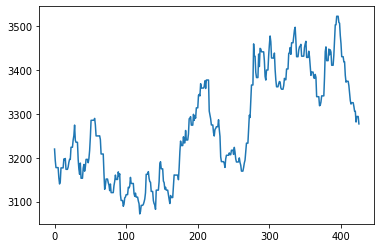

In [0]:

training_set = training_set_df.iloc[1400:1826,3:4].values

plt.plot(training_set, label = 'Data')
plt.show()

In [0]:
training_set_df.tail(10)

,Index,Unnamed: 1,Fecha (dd/mm/aaaa),TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_EfcRate,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20
1825,1826,mar,2019-12-31,3277.14,8.094726,0.042570,0.045470,0.055721,0.064371,0.010608,0.017666,0.024734,1.55,1.75,61.06,1529.30,-16.91,-0.005147,3288.138,3329.6495
1826,1827,mié,2020-01-01,3277.14,8.094726,0.042570,0.045470,0.055721,0.064371,0.010608,0.017666,0.024734,1.55,1.75,61.33,1520.95,0.00,0.000000,3287.286,3324.1200
1827,1828,jue,2020-01-02,3277.14,8.094726,0.042590,0.045902,0.055811,0.064531,0.010608,0.017666,0.024734,1.55,1.75,61.18,1540.10,0.00,0.000000,3283.904,3319.3655
1828,1829,vie,2020-01-03,3258.84,8.089127,0.042600,0.044759,0.056100,0.064821,0.008447,0.018163,0.024892,1.55,1.75,63.05,1564.50,-18.30,-0.005600,3276.862,3313.5930
1829,1830,sáb,2020-01-04,3262.05,8.090111,0.042585,0.044887,0.055864,0.064622,0.008610,0.017911,0.024917,1.55,1.75,63.16,1572.70,3.21,0.000985,3270.462,3307.9810
1830,1831,dom,2020-01-05,3262.05,8.090111,0.042585,0.044887,0.055864,0.064622,0.008610,0.017911,0.024917,1.55,1.75,63.16,1572.70,0.00,0.000000,3267.444,3302.3690
1831,1832,lun,2020-01-06,3262.05,8.090111,0.042585,0.044887,0.055864,0.064622,0.008610,0.017911,0.024917,1.55,1.75,63.27,1580.90,0.00,0.000000,3264.426,3297.2595
1832,1833,mar,2020-01-07,3262.05,8.090111,0.042570,0.045015,0.055629,0.064423,0.008773,0.017659,0.024943,1.55,1.75,62.70,1586.30,0.00,0.000000,3261.408,3292.9690
1833,1834,mié,2020-01-08,3264.26,8.090788,0.042540,0.044515,0.054818,0.063715,0.008803,0.017359,0.024996,1.55,1.75,59.61,1572.30,2.21,0.000677,3262.492,3289.6830
1834,1835,jue,2020-01-09,3254.42,8.087769,0.042550,0.044411,0.054333,0.062871,0.009567,0.017183,0.024514,1.55,1.75,59.56,1566.40,-9.84,-0.003019,3260.966,3286.2850


#Load the Data

In [0]:
def scaling_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 1
x, y = scaling_window(training_data, seq_length)

## n dias val
val_size = 9


train_size = int((len(y)-val_size) * 0.70)
test_size = len(y) - train_size - val_size


dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)-val_size])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)-val_size])))

valX = Variable(torch.Tensor(np.array(x[len(x)-val_size:len(x)])))
valY = Variable(torch.Tensor(np.array(y[len(y)-val_size:len(y)])))

#Model

In [0]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

#training

In [0]:
num_epochs = 800
learning_rate = 0.01

input_size = 1
hidden_size = 60
num_layers = 1

num_classes = 1

In [0]:
#AJUSTAR PARA INCLUIR LOSS EN TRAIN Y EN TEST

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()

    #TEST PREDICT, AND LOSS ESTIMATION

    outputs_test = lstm(testX)
    loss_test =   criterion(outputs_test, testY)

    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss train: %1.5f, loss test: %1.5f" % (epoch, loss.item(),loss_test.item()))

Epoch: 0, loss train: 0.13518, loss test: 0.59667
Epoch: 100, loss train: 0.00145, loss test: 0.00230
Epoch: 200, loss train: 0.00141, loss test: 0.00165
Epoch: 300, loss train: 0.00139, loss test: 0.00149
Epoch: 400, loss train: 0.00139, loss test: 0.00145
Epoch: 500, loss train: 0.00139, loss test: 0.00145
Epoch: 600, loss train: 0.00139, loss test: 0.00145
Epoch: 700, loss train: 0.00139, loss test: 0.00145


# pred over all data vs y all data

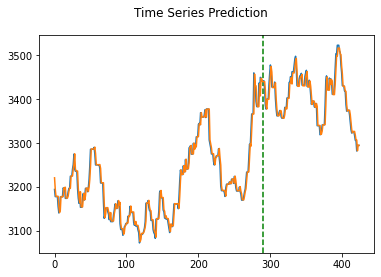

In [0]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='g', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time Series Prediction')
plt.show()

#test val

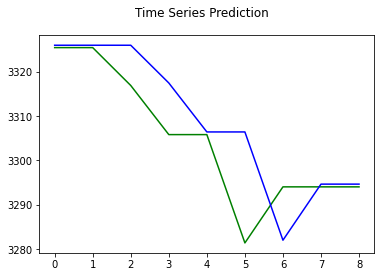

In [0]:
lstm.eval()
train_predict = lstm(valX)

data_predict = train_predict.data.numpy()
dataY_plot = valY.data.numpy()



data_predict = sc.inverse_transform(data_predict)
data_predict=data_predict#[-8:]
dataY_plot = sc.inverse_transform(dataY_plot)





plt.plot(dataY_plot,c='g')
plt.plot(data_predict,c='b')
plt.suptitle('Time Series Prediction')
plt.show()

In [0]:
dif = np.average(dataY_plot- data_predict)

mse = ((dataY_plot- data_predict)**2).mean()
rmse = np.sqrt(mse)
print('la diferencia entre la prediccion y el dato real es de '+str(dif)+'pesos')
print('el MSE entre la prediccion y el dato real es de '+str(mse))
print('el RMSE entre la prediccion y el dato real es de '+str(rmse))

la diferencia entre la prediccion y el dato real es de -4.0714245pesos
el MSE entre la prediccion y el dato real es de 110.21017
el RMSE entre la prediccion y el dato real es de 10.498103
